In [1]:
import os
import tarfile
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import urllib.request
import scipy.io
from PIL import Image

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
data_dir = '/content'
image_dir = os.path.join(data_dir,'jpg')  #/content/jpg
label_file = os.path.join(data_dir,'imagelabels.mat')
url = 'http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz'
file_path = os.path.join(data_dir,'102flowers.tgz')
urllib.request.urlretrieve(url,file_path)
with tarfile.open(file_path,'r:gz') as tar:
  tar.list()
  tar.extractall(path=data_dir)

Streaming output truncated to the last 5000 lines.
?rwxr-xr-x men/men      38318 2009-02-19 15:21:00 jpg/image_02266.jpg 
?rwxr-xr-x men/men      59135 2009-02-19 15:20:47 jpg/image_00062.jpg 
?rwxr-xr-x men/men      61470 2009-02-19 15:21:18 jpg/image_05821.jpg 
?rwxr-xr-x men/men      55335 2009-02-19 15:21:07 jpg/image_03712.jpg 
?rwxr-xr-x men/men      24281 2009-02-19 15:20:54 jpg/image_01142.jpg 
?rwxr-xr-x men/men      40836 2009-02-19 15:21:04 jpg/image_03033.jpg 
?rwxr-xr-x men/men      73085 2009-02-19 15:21:17 jpg/image_05760.jpg 
?rwxr-xr-x men/men      37638 2009-02-19 15:21:02 jpg/image_02732.jpg 
?rwxr-xr-x men/men      42141 2009-02-19 15:20:47 jpg/image_00183.jpg 
?rwxr-xr-x men/men      55137 2009-02-19 15:21:15 jpg/image_05264.jpg 
?rwxr-xr-x men/men      37223 2009-02-19 15:21:08 jpg/image_03778.jpg 
?rwxr-xr-x men/men      65333 2009-02-19 15:21:24 jpg/image_07061.jpg 
?rwxr-xr-x men/men      50527 2009-02-19 15:21:11 jpg/image_04468.jpg 
?rwxr-xr-x men/men      50

In [4]:
class FlowerDataset(Dataset):
  def __init__(self,image_dir,label_file,transform=None):
    self.image_dir = image_dir
    self.transform = transform

    #Load image labels
    mat = scipy.io.loadmat(label_file)
    self.labels = mat['labels'].flatten() - 1   #Python 0,1,2,3  Matlab 1,2,3,4

    #Load image file names
    self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    self.image_files.sort()

  def __len__(self):
    return len(self.image_files)


  def __getitem__(self,idx):
    img_name = self.image_files[idx]
    img_path = os.path.join(self.image_dir,img_name)
    image = Image.open(img_path).convert('RGB')

    if self.transform:
      image = self.transform(image)

    label = self.labels[idx]
    return image, torch.tensor(label, dtype=torch.long)

In [5]:
image_size = 64
batch_size = 64
transform = transforms.Compose([
    transforms.Resize((image_size,image_size)), #Resize all the images to 64*64
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])   #Normalized_Pixel = (pixel-mean)/STD  #(Red,Green,Blue)
])

dataset = FlowerDataset(image_dir=image_dir,label_file=label_file,transform=transform)
dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=True)

In [6]:
class ConditionalGenerator(nn.Module):
  def __init__(self,latent_dim,label_dim):
    super(ConditionalGenerator,self).__init__()
    self.label_embedding = nn.Embedding(num_classes,label_dim)
    self.model = nn.Sequential(  # ConvTranspose2d used for upsampling (upscaling)
        nn.ConvTranspose2d(latent_dim+label_dim,512,4,1,0,bias=False), #1*1
        nn.BatchNorm2d(512),                 #out_size = (input_size-1)*Stride + Kernel - 2*Padding
        nn.ReLU(),                          #Output =  (1-1)*1 + 4 - 2*0 = 4

        nn.ConvTranspose2d(512,256,4,2,1,bias=False),
        nn.BatchNorm2d(256),               #Output2 = (4-1)*2 + 4 - 2*1  = 8
        nn.ReLU(),

        nn.ConvTranspose2d(256,128,4,2,1,bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(),                       #Output = 16

        nn.ConvTranspose2d(128,64,4,2,1,bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        nn.ConvTranspose2d(64,3,4,2,1,bias=False),  #Output=64
        nn.Tanh()
    )

  def forward(self,noise,labels):
    label_emb = self.label_embedding(labels).unsqueeze(2).unsqueeze(3)  #(batch_size,label_dim,1,1)
    gen_input = torch.cat((noise,label_emb),1)
    img = self.model(gen_input)
    return img

class ConditionalDiscriminator(nn.Module):
  def __init__(self,label_dim):
    super(ConditionalDiscriminator,self).__init__()
    self.label_embedding = nn.Embedding(num_classes,label_dim)
    self.model = nn.Sequential(  #Conv2d for Downsampling (Downscaling)
      nn.Conv2d(3+label_dim,64,4,2,1,bias=False),
      nn.LeakyReLU(0.2,inplace=True),

      nn.Conv2d(64,128,4,2,1,bias=False),
      nn.BatchNorm2d(128),
      nn.LeakyReLU(0.2,inplace=True),

      nn.Conv2d(128,256,4,2,1,bias=False),
      nn.BatchNorm2d(256),
      nn.LeakyReLU(0.2,inplace=True),

      nn.Conv2d(256,512,4,2,1,bias=False),
      nn.BatchNorm2d(512),
      nn.LeakyReLU(0.2,inplace=True),

      nn.Conv2d(512,1,4,1,0,bias=False),
      nn.Sigmoid()  # Output in the range of 0 and 1, close to 1 (real) and close 0 means (fake)
    )

  def forward(self,img,labels):
    label_emb = self.label_embedding(labels).unsqueeze(2).unsqueeze(3) #(batch_size,label_dim,1,1)
    label_emb = label_emb.expand(label_emb.size(0),label_emb.size(1),img.size(2),img.size(3)) #[batch_size,label_dim,Height,Width]
    d_in = torch.cat((img,label_emb),1)
    validity = self.model(d_in)
    return validity.view(-1,1)  #[batch_size,1]

In [7]:
num_classes = 102
latent_dim = 100
label_dim = 50

#Initialize models
generator = ConditionalGenerator(latent_dim,label_dim).to(device)
discriminator = ConditionalDiscriminator(label_dim).to(device)

#Loss function & Optimizers
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(),lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(),lr=0.0002)

In [8]:
n_epochs = 100

#Training Loop
for epoch in range(n_epochs):
  for i,(imgs,labels) in enumerate(dataloader):
    label_emb = labels.to(device)
    real_imgs = imgs.to(device)

    valid = torch.ones(imgs.size(0),1,device=device)
    fake = torch.zeros(imgs.size(0),1,device=device)

    #Train Discriminator
    optimizer_D.zero_grad()
    real_loss = adversarial_loss(discriminator(real_imgs,label_emb),valid)
    noise = torch.randn(imgs.size(0),latent_dim,1,1,device=device)
    fake_imgs = generator(noise,label_emb).detach()
    fake_loss = adversarial_loss(discriminator(fake_imgs,label_emb),fake)
    d_loss = (real_loss+fake_loss)/2
    d_loss.backward()
    optimizer_D.step()

    #Train Generator
    optimizer_G.zero_grad()
    gen_imgs = generator(noise,label_emb)
    g_loss = adversarial_loss(discriminator(gen_imgs,label_emb),valid)
    g_loss.backward()
    optimizer_G.step()

  print(f"Epoch [{epoch+1}/{n_epochs}] | D Loss: {d_loss.item()} | G Loss: {g_loss.item()}") # Epoch [1/100] | D Loss:   G Loss:


Epoch [1/100] | D Loss: 0.12305408716201782 | G Loss: 4.514880180358887
Epoch [2/100] | D Loss: 0.13337111473083496 | G Loss: 3.5376176834106445
Epoch [3/100] | D Loss: 0.16153331100940704 | G Loss: 2.686065435409546
Epoch [4/100] | D Loss: 0.7093333005905151 | G Loss: 3.355379581451416
Epoch [5/100] | D Loss: 0.22899210453033447 | G Loss: 3.8302648067474365
Epoch [6/100] | D Loss: 0.19342681765556335 | G Loss: 3.707580804824829
Epoch [7/100] | D Loss: 0.04687347263097763 | G Loss: 3.222012758255005
Epoch [8/100] | D Loss: 0.3382064700126648 | G Loss: 4.04208517074585
Epoch [9/100] | D Loss: 0.28467896580696106 | G Loss: 2.36199688911438
Epoch [10/100] | D Loss: 0.22193345427513123 | G Loss: 3.7927303314208984
Epoch [11/100] | D Loss: 0.10571619123220444 | G Loss: 4.588794708251953
Epoch [12/100] | D Loss: 0.1662740409374237 | G Loss: 3.5868868827819824
Epoch [13/100] | D Loss: 0.6320278644561768 | G Loss: 3.552778720855713
Epoch [14/100] | D Loss: 0.030515437945723534 | G Loss: 4.8488

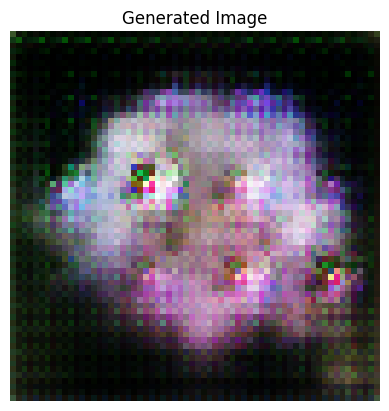

In [13]:
def generate_and_display_image(label,generator,latent_dim,num_classes):
  generator.eval()

  if label < 0 or label > num_classes:
    raise ValueError(f'Label Should be between 0 and 102')

  #Generate a batch of random noise
  noise = torch.randn(1,latent_dim,1,1,device=device)

  #Conver label to tensor
  label_tensor = torch.tensor([label],dtype=torch.long,device=device)

  #Generate image
  with torch.no_grad():
    generated_img = generator(noise,label_tensor)

  #Convert the image to numpy and set the dimension
  generated_img = generated_img.squeeze().permute(1,2,0).cpu().numpy()  #(Channel,Height,Width) (0,1,2)
  generated_img = (generated_img+1)/2  #Rescale to [0,1]

  #Display image
  plt.imshow(generated_img)
  plt.title(f"Generated Image")
  plt.axis('off')
  plt.show()

# Example
label_to_generate = 35
generate_and_display_image(label_to_generate,generator,latent_dim,num_classes)
